In [66]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

# Download file

In [2]:
file_id = "1atOZX3YXmxx-_QebbTfndeC6U_DPTL2e" # ID of the file on Google Drive
file_name = 'Updated_data_2021&2022.csv'

%run download.ipynb

# Import data

In [3]:
# File path
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
file_path = os.path.join(parent_dir, 'Data',file_name)

df = pd.read_csv(file_path)
df.head()

,DATE_DIM,DAY_OF_WEEK,BET_ACCOUNT_NUM_HASH,AGE,AGE_BAND,GENDER,TENURE_IN_DAYS,RESIDENTIAL_STATE,FOB_RACING_TURNOVER,FOB_SPORT_TURNOVER,PARI_RACING_TURNOVER,PARI_SPORT_TURNOVER,TOTAL_TURNOVER,DIVIDENDS_PAID,GROSS_MARGIN,TICKETS
0,2021-01-01,Fri,13154,67.0,65+,M,11846,WA,37.0,NaN,1081.0,NaN,1118.0,443.55,271.254275,288
1,2021-01-01,Fri,18379,54.0,45-54,M,1884,WA,40.0,NaN,NaN,NaN,40.0,0.00,40.000000,1
2,2021-01-01,Fri,559232,63.0,55-64,M,2866,WA,NaN,NaN,12.0,NaN,12.0,9.50,2.041720,5
3,2021-01-01,Fri,698904,69.0,65+,M,2100,WA,NaN,NaN,1223.5,NaN,1223.5,267.91,245.117147,40
4,2021-01-01,Fri,762921,67.0,65+,M,4766,WA,NaN,NaN,17.5,NaN,17.5,0.00,3.504075,5


In [4]:
# DATE_DIM: datetime
df['DATE_DIM'] = pd.to_datetime(df['DATE_DIM'], format='%Y-%m-%d')

# BET_ACCOUNT_NUM_HASH: string
df['BET_ACCOUNT_NUM_HASH'] = df['BET_ACCOUNT_NUM_HASH'].astype('O')

# Fillna
df['AGE'].fillna(44, inplace=True)

# drop
df.drop(['DAY_OF_WEEK', 'AGE'], axis=1, inplace=True)

# More than zero
df = df[df['TOTAL_TURNOVER'] > 0]

In [50]:
df['YEAR_WEEK'] = df['DATE_DIM'].dt.year * 100 + df['DATE_DIM'].dt.week

df['RACING_TURNOVER'] = df[['FOB_RACING_TURNOVER', 'PARI_RACING_TURNOVER']].sum(axis=1)

df['WIN_LOSS'] = (df['DIVIDENDS_PAID'] >= df['TOTAL_TURNOVER']).astype('int32')

In [132]:
y_202102 = df[df['YEAR_WEEK'] == 202102].groupby('BET_ACCOUNT_NUM_HASH').TOTAL_TURNOVER.sum()

X_202101 = df[df['YEAR_WEEK'] == 202101].groupby('BET_ACCOUNT_NUM_HASH').agg({
    'BET_ACCOUNT_NUM_HASH': np.size,
    'AGE_BAND' : max,
    'GENDER' : max,
    'TENURE_IN_DAYS' : max,
    'RACING_TURNOVER' : sum,
    'TOTAL_TURNOVER' : sum,
    'TICKETS' : sum,
    'WIN_LOSS' : sum
})

X = pd.merge(X_202101, y_202102, left_index=True, right_index=True, how='left')

X.columns = ['FREQ', 'AGE_BAND', 'GENDER', 'TENURE_IN_DAYS', 'RACING_TURNOVER', 'TOTAL_TURNOVER_7', 'TICKETS', 'WIN_LOSS', 'TOTAL_TURNOVER']

X['FREQ'] = X['FREQ'] / 7
X['WIN_LOSS_RATIO'] = X['WIN_LOSS'] / (X['FREQ'] * 7) 
X['RACING_RATIO'] = X['RACING_TURNOVER'] / X['TOTAL_TURNOVER_7']
X['TOTAL_TURNOVER'].fillna(0,inplace=True)

In [133]:
X_train = X.drop(['AGE_BAND', 'GENDER', 'TENURE_IN_DAYS', 'RACING_TURNOVER', 'WIN_LOSS', 'RACING_RATIO'], axis=1)
X_train

,FREQ,TOTAL_TURNOVER_7,TICKETS,TOTAL_TURNOVER,WIN_LOSS_RATIO
BET_ACCOUNT_NUM_HASH,,,,,
13154,1.000000,3393.02,943,1917.5,0.000000
18379,0.142857,1000.00,1,50.0,0.000000
433164,0.285714,244.50,482,93.5,0.000000
559232,0.857143,135.50,51,102.0,0.500000
698904,1.000000,1597.00,112,1255.0,0.285714
...,...,...,...,...,...
4293715592,1.000000,337.12,124,289.0,0.142857
4293727606,0.142857,412.00,1,0.0,0.000000
4294378139,0.142857,0.50,1,65.0,0.000000


In [161]:
X_train.groupby('FREQ').TOTAL_TURNOVER.mean()

FREQ
0.142857     141.038129
0.285714     282.107794
0.428571     453.491540
0.571429     635.839325
0.714286     787.683497
0.857143    1009.247581
1.000000    1433.528390
Name: TOTAL_TURNOVER, dtype: float64

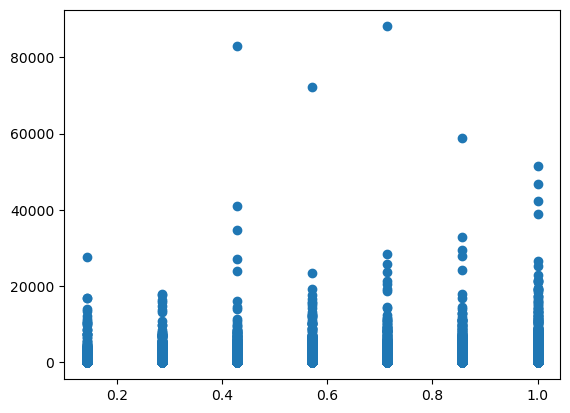

In [158]:
plt.scatter(X_train['FREQ'], X_train['TOTAL_TURNOVER'])

In [134]:
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse

In [135]:
X = X_train.drop('TOTAL_TURNOVER', axis=1).to_numpy()
y = X_train['TOTAL_TURNOVER'].to_numpy().reshape(-1,1)

In [136]:
X = sm.add_constant(X)

model = sm.OLS(y, X) 
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.435
Model:                            OLS   Adj. R-squared:                  0.435
Method:                 Least Squares   F-statistic:                     6928.
Date:                Thu, 22 Jun 2023   Prob (F-statistic):               0.00
Time:                        15:57:28   Log-Likelihood:            -3.0732e+05
No. Observations:               35984   AIC:                         6.146e+05
Df Residuals:                   35979   BIC:                         6.147e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         66.0040     12.518      5.273      0.000      41.468      90.540
x1           213.5951     26.193      8.155      0.000     162.257     264.934
x2             0.6847      0.004    153.687      0.000       0.676       0.693
x3            -0.1209      0.040     -3.012      0.003      -0.200      -0.042
x4           -71.5153     23.400     -3.056      0.002    -117.381     -25.650
==============================================================================
Omnibus:                    75375.730   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1412161971.474
Skew:                          17.411   Prob(JB):                         0.00
Kurtosis:                     972.870   Cond. No.                     7.11e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.11e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [137]:
y_pred = results.predict(X)

In [143]:
y.flatten() 

array([1917.5,   50. ,   93.5, ...,   65. ,  625. ,   85. ])

In [144]:
y_pred

array([2488.73498587,  781.09323092,  236.14287492, ...,   96.73899534,
        951.82341256,  131.78307357])

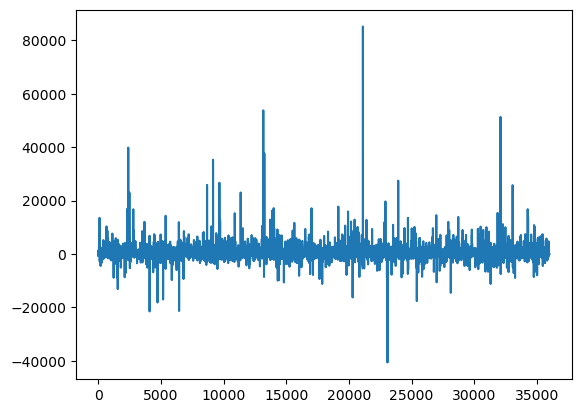

In [146]:
plt.plot(y.flatten()  - y_pred)

In [155]:
sum((y.flatten()  - y_pred)**2/35984)**0.5

1238.3239869417434

In [156]:
sum((y.flatten()  - y_pred)**2/35984)

1533446.2966352953

In [148]:
X_train['TOTAL_TURNOVER_7'].mean()

511.874452812361

In [150]:
var = X_train['TOTAL_TURNOVER_7'].var()
var**0.5

1569.9263492093514

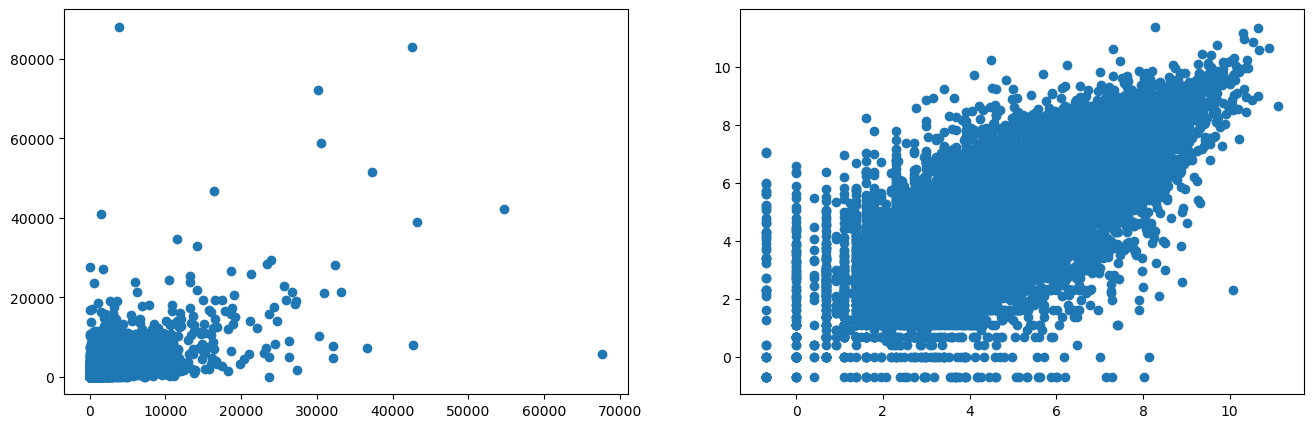

In [79]:
fig, ax = plt.subplots(1,2, figsize=(16,5))
ax[0].scatter(X['TOTAL_TURNOVER_REAL'], X['TOTAL_TURNOVER_PRED'])
ax[1].scatter(np.log(X['TOTAL_TURNOVER_REAL']), np.log(X['TOTAL_TURNOVER_PRED']))